In [1]:
import os

import sys

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow as tf

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization

# Translation

In [2]:
with open('ukr.txt', encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

text_pairs = []


for line in lines:
    eng, ukr, usless = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

In [3]:
for _ in range(5):
    print(random.choice(text_pairs))

('I gave him advice, to which he paid no attention.', '[start] Я дав йому пораду, на яку він не звернув уваги. [end]')
('Tom lived in the woods.', '[start] Том жив у лісі. [end]')
("I'm very impressed by your work.", '[start] Я під сильним враженням від твоєї роботи. [end]')
('Tom and Mary have the flu.', '[start] У Тома та Мері грип. [end]')
('Hello, may I speak to Tom?', '[start] Алло, можна поговорити з Томом? [end]')


In [4]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

158705 total pairs
111095 training pairs
23805 validation pairs
23805 test pairs


In [5]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

In [6]:
def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ukr[:, :-1],
        },
        ukr[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [7]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return tf.math_not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, None, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, None]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1])],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [11]:
epochs = 50

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [18]:
ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 50


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated)

Tom knew that he would win.
[start] Том знав що він виграє [end]
Tom isn't much shorter than Mary.
[start] Том не набагато краще від Мері [end]
He made an apology to us for being late.
[start] Він зробив нам щоб ми [UNK] [end]
Clap your hands.
[start] [UNK] [end]
We're positive.
[start] Ми [UNK] [end]


# Transformers

In [23]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# classifier = pipeline('sentiment-analysis')

generator = pipeline("text-generation", model="benjamin/gpt2-wechsel-ukrainian")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.4.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'lm_head.weight']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [24]:
generator(
    "Ця лабораторна робота",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Ця лабораторна робота №4. Побудова графіків залежності температури навколишнього середовища від складу атмосферного повітря Тема: Побудова графіків залежності температури навколишнього середовища від складу атмосферного'},
 {'generated_text': 'Ця лабораторна робота з дисципліни “Загальна екологія”. Тема: „Кліматичні пояси України”. Студента групи ОЛТ-023 Грица'}]

In [25]:
generator(
    "За цю роботу я можу отримати",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "За цю роботу я можу отримати сертифікат на 1-3 роки, а потім ще чотири-п'ять років - за свій рахунок. Звичайно, я"},
 {'generated_text': 'За цю роботу я можу отримати 3 тис. грн. на тиждень. Якщо я отримую по 12000, то можна отримати 2000 грн. на місяць'}]

In [26]:
generator(
    "Як умру то поховайте",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Як умру то поховайте Мене на Голгофі» (Лк. 26, 32). Ісус сказав Йому прийти на допомогу, щоб воскре'},
 {'generated_text': 'Як умру то поховайте, не будем же ми з вами вічним стогнати.” Так встає з дивана Христе мій'}]

In [27]:
generator(
    "Залиш надію всяк, хто сюди входить.",
    max_length=30,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Залиш надію всяк, хто сюди входить. І як тут бути? Невже ні? (Ф.Тютчев, "На шляху до щастя'},
 {'generated_text': 'Залиш надію всяк, хто сюди входить. Дякую за допомогу та підтримку!\nВітаю з новим проектом від компанії Oxford! Це сайт'}]

# Image stylization

In [29]:
from keras.applications import vgg19

base_image_path = keras.utils.get_file("BezGldu.jpeg", "https://i.imgur.com/BezGldu.jpeg")
style_reference_image_path = keras.utils.get_file(
    "lOiiydF.jpeg", "https://i.imgur.com/lOiiydF.jpeg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

173980/173980 [==============================] - 0s 0us/step


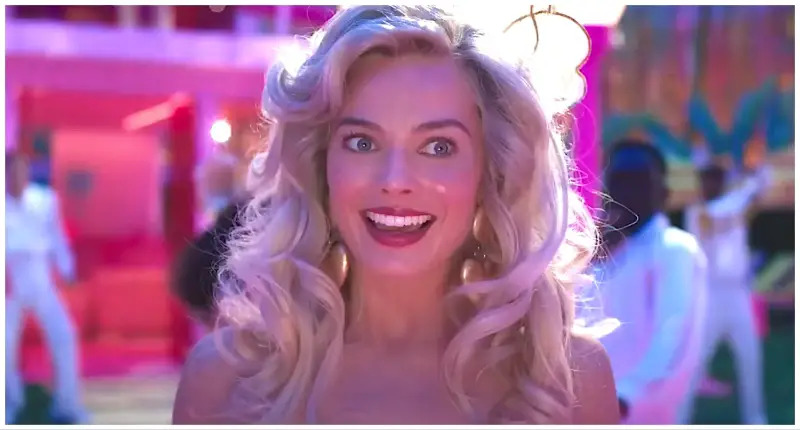

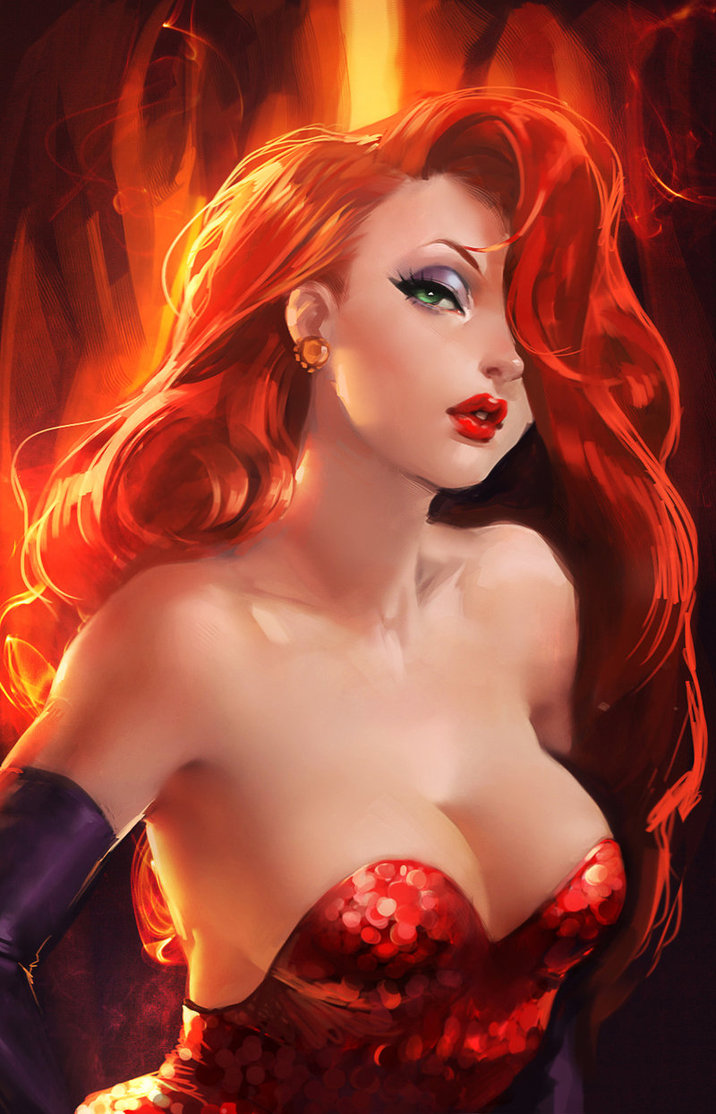

In [30]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [31]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [32]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [33]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 5s 0us/step


In [34]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [35]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [36]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=50, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 10: loss=13219.32


KeyboardInterrupt: 

In [ ]:
display(Image(result_prefix + "_at_iteration_1000.png"))